# Randomization Inference, in W241

In [1]:
import pandas as pd
import numpy as np 
from scipy import stats as scipy
import matplotlib.pyplot as plt
%matplotlib inline  

In [18]:
data = pd.DataFrame({'donation' : [500,100,100,50,25,25,0,0,0,0,25,20,15,15,10,5,5,5,0,0], 
                     'treatment' : [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0]})
data

,donation,treatment
0,500,1
1,100,1
2,100,1
3,50,1
4,25,1
5,25,1
6,0,1
7,0,1
8,0,1
9,0,1


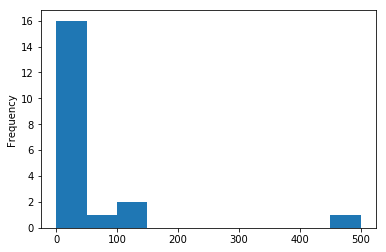

In [3]:
data['donation'].plot(kind='hist')

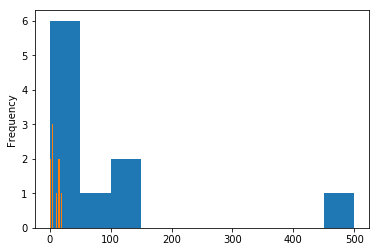

In [4]:
data.loc[range(0,10),'donation'].plot(kind='hist')
data.loc[range(11,20),'donation'].plot(kind='hist')

Goodness, it sure *looks* like these are different distributions! Let's run the classic test; a difference in means. 

In [5]:
scipy.stats.ttest_ind(a=data.loc[range(0,10),'donation'], 
                      b=data.loc[range(11,20),'donation'])

Ttest_indResult(statistic=1.4028829045195756, pvalue=0.17865138448768006)

*WHAT GIVES!?* 

# What is the _treatment_ effect of being in treatment vs. control? 
Start by thinking at the individual level -- how should we conceptualize a treatment effect? How does `data2` make clear that this is either *hard* or *impossible*? 

# How _different_ are the treatment and control groups? 
Given your answer to the first question, how should we think about a statement of a causal effect? 
One way to think about a statistic at the group level, and then to compare these statistics between the treatment and control groups. 

The most commonly thought of statistic is the mean. We might calculate a group mean in the following way: 

In [6]:
data.groupby('treatment').mean()

,donation
treatment,
0,10
1,80


Aha! So, the treatment group mean was **80** and the control group mean was **10**; and the ATE is **10**. But, how *surprising* is this ATE?

# Potential Outcomes. A class in 2 minutes. 
Represent our data differently: 

# Randomization Inference 

What if there were *no effect* of the treatment? Stick with the donations example, and think of a particular person (Koch Brother #1). 

- If I place him in **treatment**, think about what his *potential outcome* might be? This is the amount that he would donate if we were to place him into treatment. 
- If I place him in **control**, think about what his *potential outcome* to might be? This is the amount that he would donate if we were to place him into control. 

Is there any difference in this amount that you thought of? 

# Potential Outcomes, and Primer

We just thought about potential outcomes. These are the outcomes that we could *potentially* observe through a design decision. If we choose to put someone into the treatment group, we can realize their **potential outcome to treatment**. But would *potentially* could have seen their **potential outcome to control**. 

This difference is the way that we structure our *counterfactual reasoning* framework for the course. 

In data, it might look like: 

In [7]:
data2 = pd.DataFrame({
    'donation_control': np.append(np.repeat(np.nan, 10), [25,20,15,15,10,5,5,5,0,0]), 
    'donation_treatment': np.append([500,100,100,50,25,25,0,0,0,0],np.repeat(np.nan, 10)), 
    'treatment': np.append(np.repeat(1,10), np.repeat(0,10))
})
data2.head()

,donation_control,donation_treatment,treatment
0,NaN,500.0,1
1,NaN,100.0,1
2,NaN,100.0,1
3,NaN,50.0,1
4,NaN,25.0,1


In [8]:
data2.tail()

,donation_control,donation_treatment,treatment
15,5.0,NaN,0
16,5.0,NaN,0
17,5.0,NaN,0
18,0.0,NaN,0
19,0.0,NaN,0


But, what if the *sharp null* the quantity that we just saw with the Koch brother were to be true? What if there actually were no treatment-control difference between the two groups? 

... 

Wouldn't we *sort of* be able to fill out that `data2` frame? 

In [9]:
data2 = pd.DataFrame({
    'donation_control': np.append([500,100,100,50,25,25,0,0,0,0], [25,20,15,15,10,5,5,5,0,0]), 
    'donation_treatment': np.append([500,100,100,50,25,25,0,0,0,0], [25,20,15,15,10,5,5,5,0,0]), 
    'treatment': np.append(np.repeat(1,10), np.repeat(0,10))
})

In [10]:
data2

,donation_control,donation_treatment,treatment
0,500,500,1
1,100,100,1
2,100,100,1
3,50,50,1
4,25,25,1
5,25,25,1
6,0,0,1
7,0,0,1
8,0,0,1
9,0,0,1


And, if that were true, then can't we *imagine* a different randomization? One that would have revealed a different set of potential outcomes in the treatment and control groups? 

In [11]:
data2['treatment'] = data2['treatment'].sample(frac=1).reset_index(drop=True)

In [12]:
data2

,donation_control,donation_treatment,treatment
0,500,500,1
1,100,100,1
2,100,100,1
3,50,50,1
4,25,25,0
5,25,25,0
6,0,0,0
7,0,0,0
8,0,0,0
9,0,0,0


With this, we could calculate how large the group difference might be, under one of these other assignments that was possible. 

In [13]:
data2.groupby('treatment').mean().diff()

,donation_control,donation_treatment
treatment,,
0,NaN,NaN
1,78.0,78.0


Why not do this a large number of times, to identify the *entire* range of possible assignemnts? 

In [14]:
def ri_iteration(data): 
    outcomes = data['donation']
    treatment = data['treatment']
    
    treatment = np.random.permutation(treatment)
    
    mean_control = outcomes[treatment==0].mean()
    mean_treatment = outcomes[treatment==1].mean()
    
    ate = mean_treatment - mean_control 
    
    return(ate)

In [15]:
res = []

for loop in range(0,1000): 
    res.append(ri_iteration(data=data))


(array([  88.,  186.,  153.,   48.,    0.,    2.,   95.,  212.,  157.,   59.]),
 array([-78. , -61.9, -45.8, -29.7, -13.6,   2.5,  18.6,  34.7,  50.8,
         66.9,  83. ]),
 <a list of 10 Patch objects>)

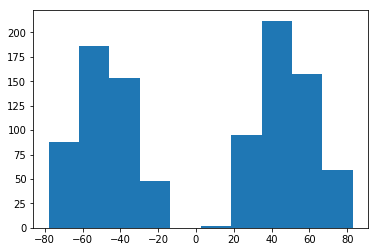

In [16]:
plt.hist(res)

In [17]:
np.mean([np.abs(i) > 70 for i in res])

0.055

So, through `RI`, with some principled assumptions, we've pretty considerably changed the inference that we would conclude from this test. Hizzah! 